In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection  import train_test_split


### **데이터 불러오기**

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/s_project/data/df_3.csv', index_col=0)


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32901 entries, 0 to 15004
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  32901 non-null  object
 1   label    32901 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 771.1+ KB


In [ ]:
data['label'].value_counts()

0    20676
1    12225
Name: label, dtype: int64

In [ ]:
data.head(5)

,content,label
0,이종석 한효주 나오는 드라마 이후로 드라마 안봤다. 2년전인가?? 좀 신선했었지. ...,0
1,씨바알..노무노무 술프노... 오늘 저녁은 꽂등심이다ㅠㅜ,0
2,짱깨 꺼라ㅡ패쓰,0
3,그들의 사생활 ~ 고인이된 설리를 위해서라도 모두 조용하길 지금 누굴 탓한다고 무슨...,1
4,아무리 법이 뭣같아도 무슨 자격으로 개인의 신상정보를 불특정 다수에게 공개하는지 도...,1


In [ ]:
print('훈련용 데이터 개수 :',len(data))  # 총 데이터수 

훈련용 데이터 개수 : 32901


In [ ]:
# 중복되지 않은 유니크한 리뷰
data['content'].nunique()


28049

In [ ]:
data.drop_duplicates(subset=['content'], inplace=True)
# 중복제거 

In [ ]:
print('총 샘플의 수 :',len(data))

총 샘플의 수 : 28049


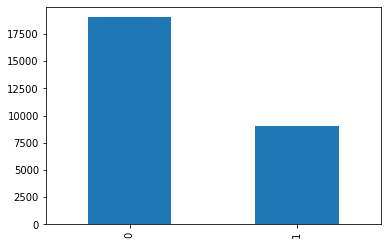

In [ ]:
data['label'].value_counts().plot(kind = 'bar') # 일반부정 분포  0 |욕  / 1 정상

In [ ]:
print(data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0  19015
1      1   9034


In [ ]:
print(data.isnull().values.any()) # null 확인 

False


In [ ]:
# 훈련 및 테스트 데이터 분리
train_data, test_data = train_test_split(data,test_size=0.2,random_state=2021)

In [ ]:
train_data['label'].value_counts()

0    15234
1     7205
Name: label, dtype: int64

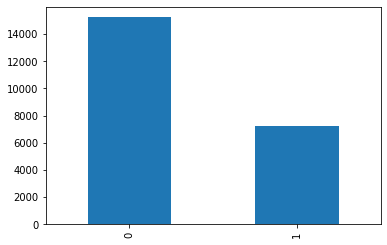

In [ ]:
train_data['label'].value_counts().plot(kind='bar')
## 불균형 : 악플위주의 데이터만 추출

In [ ]:
# 한글 공백 제거
train_data['content'] = train_data['content'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data[:5]

<ipython-input-131-c09adcc77ed0>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['content'] = train_data['content'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


,content,label
15640,이 퇴물놈들이 년해먹어도 방탄소년단 반년 유투브 조회수도 못따라감 ㅋㅋㅋㅋ,0
12356,리즈시절때 인기는 문희준강타장우혁토니이재원 순이었지 문희준은 지디급이었고 강타부인은...,0
6545,꼴리면 정상이냐,0
9349,음주는했지만 음주운전은안했다,1
4216,지랄 이럴때만 기독교 인용하냐,0


In [ ]:
# 한글없는 리뷰 비어있는 값 :125
train_data['content'] = train_data['content'].str.replace('^ +', "") # white space 데이터를 empty value로 변경
train_data['content'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

content    18
label       0
dtype: int64


<ipython-input-132-7f422aaffb25>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['content'] = train_data['content'].str.replace('^ +', "") # white space 데이터를 empty value로 변경


In [ ]:
train_data.loc[train_data.content.isnull()][:5]

,content,label
4770,NaN,1
12127,NaN,1
8441,NaN,1
7709,NaN,1
13584,NaN,1


In [ ]:
#  의미없는 데이터 제거 
train_data = train_data.dropna(how = 'any')
print(len(train_data))

22421


In [ ]:
# test_dat 전처리 
test_data.drop_duplicates(subset = ['content'], inplace=True) # content 열에서 중복인 내용이 있다면 중복 제거
test_data['content'] = test_data['content'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['content'] = test_data['content'].str.replace('^ +', "") # 공백은 empty 값으로 변경
test_data['content'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 5604


<ipython-input-135-4f84a66914fa>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['content'] = test_data['content'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
<ipython-input-135-4f84a66914fa>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['content'] = test_data['content'].str.replace('^ +', "") # 공백은 empty 값으로 변경


# **토큰화**

In [ ]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [ ]:
from konlpy.tag import Okt

In [ ]:
 #Okt 형태소 분석기
okt = Okt()

In [ ]:
X_train = []
for sentence in tqdm(train_data['content']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_train.append(stopwords_removed_sentence)

100%|██████████| 22421/22421 [02:11<00:00, 170.02it/s]


In [ ]:
print(X_train[:3])

[['퇴물놈', '년', '해먹', '어', '방탄소년단', '반년', '유투브', '조회', '수도', '못', '따라가다', 'ㅋㅋㅋㅋ'], ['리즈시절', '때', '인기', '문희준', '강타', '장우혁', '토니', '이재원', '순', '이다', '문희준', '지', '디', '급', '이다', '강타', '부인', '전국', '수만', '명', '있다', '장우혁', '남자', '팬', '엄청', '많다', '그렇다', '토니', '이재원', '급', '쩌리', '이다'], ['꼴리다', '정상', '이냐']]


In [ ]:
X_test = []
for sentence in tqdm(test_data['content']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_test.append(stopwords_removed_sentence)

100%|██████████| 5604/5604 [00:31<00:00, 175.86it/s]


In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)


In [ ]:
print(tokenizer.word_index)

{'을': 1, '보다': 2, '아니다': 3, '있다': 4, '다': 5, '되다': 6, '없다': 7, '새끼': 8, '같다': 9, '로': 10, 'ㅋㅋ': 11, '안': 12, '이다': 13, '만': 14, '에서': 15, '못': 16, '고': 17, '나': 18, '사람': 19, '여자': 20, '왜': 21, '저': 22, '아': 23, '진짜': 24, '들다': 25, '좋다': 26, '그렇다': 27, '그': 28, '하고': 29, '게': 30, '거': 31, 'ㅋㅋㅋ': 32, '네': 33, '가다': 34, '말': 35, '적': 36, '야': 37, '년': 38, '나오다': 39, '니': 40, '않다': 41, '지': 42, '남자': 43, '더': 44, '것': 45, '인': 46, '먹다': 47, '뭐': 48, '개': 49, '받다': 50, '애': 51, '많다': 52, '라': 53, '좆': 54, '면': 55, '내': 56, '생각': 57, '알다': 58, '오다': 59, '때': 60, '그냥': 61, '치다': 62, '인데': 63, '지다': 64, '존나': 65, '한테': 66, '너무': 67, '맞다': 68, '놈': 69, '일': 70, '돈': 71, '하': 72, '한국': 73, '냐': 74, '임': 75, '모르다': 76, '들이다': 77, '살다': 78, '이나': 79, '까지': 80, '나다': 81, '씨발': 82, '랑': 83, 'ㅋㅋㅋㅋ': 84, '딱': 85, '한남': 86, '이렇다': 87, '서': 88, '이기': 89, '병신': 90, 'ㅋ': 91, '안되다': 92, '나라': 93, '쓰다': 94, '시키다': 95, '자다': 96, '해주다': 97, '근데': 98, '페미': 99, '또': 100, '충': 101, '만들다': 102, '싶다': 103, '주다':

In [ ]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 23221
등장 빈도가 1번 이하인 희귀 단어의 수: 10690
단어 집합에서 희귀 단어의 비율: 46.03591576590155
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.6798876412230035


In [ ]:
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 12532


In [ ]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
print(X_train[:3])

[[38, 2352, 553, 3099, 9159, 3309, 5366, 938, 16, 1800, 84], [6167, 60, 644, 3862, 4248, 9160, 5367, 9161, 1034, 13, 3862, 42, 1176, 283, 13, 4248, 1685, 1870, 4739, 237, 4, 9160, 43, 379, 598, 52, 27, 5367, 9161, 283, 7292, 13], [970, 464, 186]]


In [ ]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

In [ ]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

In [ ]:
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

22390
22390


/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:4454: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


댓글의 최대 길이 : 249
댓글의 평균 길이 : 12.4970075926753


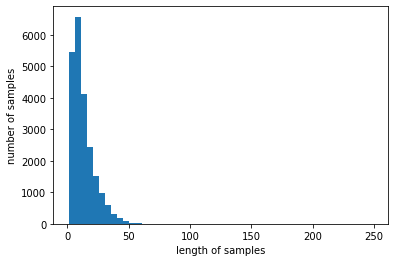

In [ ]:
print('댓글의 최대 길이 :',max(len(review) for review in X_train))
print('댓글의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [ ]:
max_len = 40
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 40 이하인 샘플의 비율: 98.4412684234033


In [ ]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [ ]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
280/280 [==============================] - ETA: 0s - loss: 0.4876 - acc: 0.7544
Epoch 1: val_acc improved from -inf to 0.79075, saving model to best_model.h5
280/280 [==============================] - 37s 109ms/step - loss: 0.4876 - acc: 0.7544 - val_loss: 0.4142 - val_acc: 0.7908
Epoch 2/15
280/280 [==============================] - ETA: 0s - loss: 0.3583 - acc: 0.8330
Epoch 2: val_acc improved from 0.79075 to 0.79544, saving model to best_model.h5
280/280 [==============================] - 29s 105ms/step - loss: 0.3583 - acc: 0.8330 - val_loss: 0.4069 - val_acc: 0.7954
Epoch 3/15
280/280 [==============================] - ETA: 0s - loss: 0.3200 - acc: 0.8572
Epoch 3: val_acc improved from 0.79544 to 0.80147, saving model to best_model.h5
280/280 [==============================] - 30s 109ms/step - loss: 0.3200 - acc: 0.8572 - val_loss: 0.4193 - val_acc: 0.8015
Epoch 4/15
280/280 [==============================] - ETA: 0s - loss: 0.2949 - acc: 0.8715
Epoch 4: val_acc did not

In [ ]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

176/176 [==============================] - 5s 24ms/step - loss: 0.4248 - acc: 0.7993

 테스트 정확도: 0.7993


In [ ]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 일반댓글 입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 악플댓글 입니다.\n".format((1 - score) * 100))

In [ ]:
sentiment_predict('미친년 ')

1/1 [==============================] - 0s 459ms/step
88.87% 확률로 악플댓글 입니다.



In [ ]:
sentiment_predict('좋은')

1/1 [==============================] - 0s 31ms/step
78.99% 확률로 일반댓글 입니다.



In [ ]:
sentiment_predict('개 노무 자식')

1/1 [==============================] - 0s 22ms/step
57.18% 확률로 악플댓글 입니다.



In [ ]:
sentiment_predict('안녕')

1/1 [==============================] - 0s 25ms/step
63.90% 확률로 일반댓글 입니다.



In [ ]:
sentiment_predict('사랑한다')

1/1 [==============================] - 0s 29ms/step
87.53% 확률로 일반댓글 입니다.



In [ ]:
sentiment_predict('돼지 같은 놈')

1/1 [==============================] - 0s 21ms/step
95.13% 확률로 악플댓글 입니다.



기존 악플데이터셋에 혐오데이터 추가 
데이터 추가시 모델의 정확도는 높아지나 라벨링이 잘못된 경우 실제 테스트시 문제가 발생한다. 

BiLSTM : 게이트 기법을 통해 순환 신경 회로망(RNN)의 한계를 극복한 모델인 LSTM을 순방향뿐 아니라 역방향의 결과를 함께 이용하는 모델

In [ ]:
import re
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size,100))
model.add(Bidirectional(LSTM(100)))
model.add(Dense(1,activation='sigmoid'))

In [ ]:
es = EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=10)
mc = ModelCheckpoint('best_model.h5',monitor='val_acc',mode='max',verbose=1,save_best_only=True)

In [ ]:
model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['acc'])
history = model.fit(X_train, y_train,
                    epochs=200,
                    callbacks=[es,mc],
                    batch_size=256,
                    validation_split=0.2)

Epoch 1/200
70/70 [==============================] - ETA: 0s - loss: 0.5319 - acc: 0.7263
Epoch 1: val_acc improved from -inf to 0.79187, saving model to best_model.h5
70/70 [==============================] - 37s 449ms/step - loss: 0.5319 - acc: 0.7263 - val_loss: 0.4282 - val_acc: 0.7919
Epoch 2/200
70/70 [==============================] - ETA: 0s - loss: 0.3627 - acc: 0.8331
Epoch 2: val_acc improved from 0.79187 to 0.80058, saving model to best_model.h5
70/70 [==============================] - 30s 424ms/step - loss: 0.3627 - acc: 0.8331 - val_loss: 0.4086 - val_acc: 0.8006
Epoch 3/200
70/70 [==============================] - ETA: 0s - loss: 0.3025 - acc: 0.8673
Epoch 3: val_acc improved from 0.80058 to 0.80482, saving model to best_model.h5
70/70 [==============================] - 35s 500ms/step - loss: 0.3025 - acc: 0.8673 - val_loss: 0.4150 - val_acc: 0.8048
Epoch 4/200
70/70 [==============================] - ETA: 0s - loss: 0.2636 - acc: 0.8855
Epoch 4: val_acc did not improve f

In [ ]:
loaded_model = load_model('best_model.h5')
print('테스트 정확도 : %.4f'%(loaded_model.evaluate(X_test, y_test)[1]))


176/176 [==============================] - 6s 31ms/step - loss: 0.4220 - acc: 0.8012
테스트 정확도 : 0.8012


In [ ]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣]','',new_sentence)
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen=max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측

  if(score > 0.7):
    print("{:.2f}% 확률로 일반 댓글입니다.".format(score * 100))
  elif score < 0.3:
    print("{:.2f}% 확률로 악성 댓글입니다.".format((1 - score) * 100))  
  else:
    print("{:.2f}% 확률로 애매합니다.".format((1 - score) * 100))

In [ ]:
sentiment_predict('좋다')

1/1 [==============================] - 1s 1s/step
80.25% 확률로 일반 댓글입니다.


In [ ]:
sentiment_predict('미친년')

1/1 [==============================] - 0s 115ms/step
85.62% 확률로 악성 댓글입니다.


In [ ]:
sentiment_predict('모르겠어요')

1/1 [==============================] - 0s 95ms/step
77.55% 확률로 일반 댓글입니다.


In [ ]:
sentiment_predict('ㅅ ㄲ')

1/1 [==============================] - 0s 24ms/step
46.48% 확률로 애매합니다.
